In [1]:
import numpy as np
import sympy as smp
from threading import Thread

In [2]:
def SY4(f, x0, v0, params, h=0.001, t0=0.0, tFin=10.0):
    w0 = - 2**(3/2)/(2.0-2**(3/2))
    w1 = 1/(2.0-2**(3/2))
    c1 = c4 = w1/2.0
    c2 = c3 = (w0+w1)/2.0
    d1 = d3 = w1
    d2 = w0
    t = t0
    y = np.zeros(shape=(len(x0), 1))
    y[:, 0] = x0
    vy = np.zeros(shape=(len(v0), 1))
    vy[:, 0] = v0
    timeArray = np.array([])
    i = 0
    while t<tFin:
        x0 = y[:, i]
        v0 = vy[:, i]
        x1 = x0 + c1 * v0 * h
        v1 = v0 + d1 * f(x1, v0, t, params) * h
        x2 = x1 + c2 * v1 * h
        v2 = v1 + d2 * f(x2, v1, t, params) * h
        x3 = x2 + c3 * v2 * h
        v3 = v2 + d3 * f(x3, v2, t, params) * h
        x4 = x3 + c4 * v3 * h
        v4 = v3
        y = np.column_stack((y, x4))
        vy = np.column_stack((vy, v4))
        t = t + h
        i = i + 1
        timeArray = np.append(timeArray, t)
    timeArray = np.append(timeArray, t)
    return y, vy, timeArray


In [3]:
theta1, theta2, omega1, omega2 = smp.symbols("theta1, theta2, omega1, omega2", cls=smp.Function)
m1, m2, l1, l2, g, t = smp.symbols("m1 m2 l1 l2 g t")

theta1 = theta1(t)
theta2 = theta2(t)
omega1 = smp.diff(theta1, t)
omega2 = smp.diff(theta2, t)
alpha1 = smp.diff(omega1, t)
alpha2 = smp.diff(omega2, t)

T = 1/2 * (m1 * (l1**2 * omega1**2) + m2 * (l1**2 * omega2**2 + l2**2 * omega2**2 + 2 * omega1 * omega2 * l1 * l2 * smp.cos(theta1 - theta2)))
V = -g * (m1 * l1 * smp.cos(theta1) + m2 * (l1 * smp.cos(theta1) + l2 * smp.cos(theta2)))

L = T - V
LE1 = smp.diff(smp.diff(L, omega1), t) - smp.diff(L, theta1).simplify()
LE2 = smp.diff(smp.diff(L, omega2), t) - smp.diff(L, theta2).simplify()

sols = smp.solve([LE1, LE2], [alpha1, alpha2])

omega1d = sols[alpha1]
omega2d = sols[alpha2]

dtheta1_dt = smp.lambdify(omega1, omega1)
dtheta2_dt = smp.lambdify(omega2, omega2)

domega1_dt = smp.lambdify((t, g, m1, m2, l1, l2, theta1, theta2, omega1, omega2), omega1d)
domega2_dt = smp.lambdify((t, g, m1, m2, l1, l2, theta1, theta2, omega1, omega2), omega2d)

def doublePendulumVerlet(x0, v0, t, params):
    the1, the2 = x0
    z1, z2 = v0
    g, m1, m2, l1, l2 = params
    return np.array([
        domega1_dt(t, g, m1, m2, l1, l2, the1, the2, z1, z2),
        domega2_dt(t, g, m1, m2, l1, l2, the1, the2, z1, z2),
    ])

y,vy,t = SY4(doublePendulumVerlet, np.array([0.0, 0.0]), np.array([0.1, 0.0]), params=(9.8, 1.0, 0.01, 1.0, 0.01), h=1e-3)
print(t.shape)

def doublePendulum(x0, t, params):
    the1, z1, the2, z2 = x0
    g, m1, m2, l1, l2 = params
    return np.array([
        dtheta1_dt(z1),
        domega1_dt(t, g, m1, m2, l1, l2, the1, the2, z1, z2),
        dtheta2_dt(z2),
        domega2_dt(t, g, m1, m2, l1, l2, the1, the2, z1, z2),
    ])


(10002,)


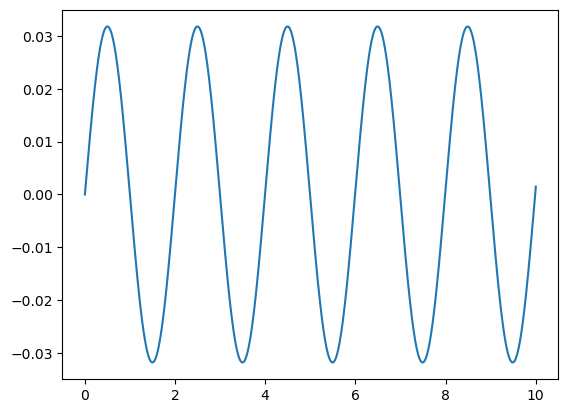

In [4]:
import matplotlib.pyplot as plt

plt.plot(t,y[0])

In [5]:
def SimplePendulum(x0, v0, t, params):
    g, l = params
    theta = x0
    thetadot = -g/l * np.sin(theta)
    return thetadot

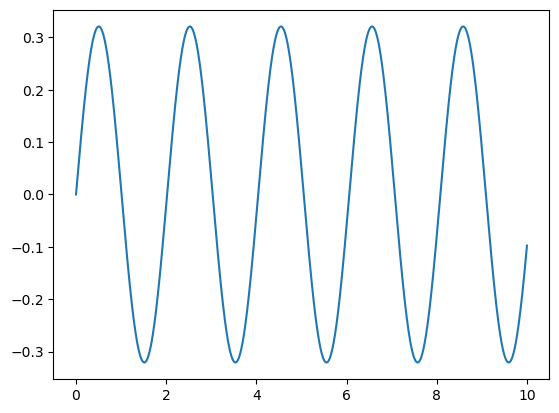

In [6]:
y, vy, t = SY4(SimplePendulum, np.array([0.0]), np.array([1.0]), params=(9.8, 1.0))
plt.plot(t,y[0])

In [7]:
def RK4(f, x0, params=None, t0 = 0.0, h = 0.01, tFin = 10.0):
    y = np.zeros(shape=(len(x0), 1))
    k1 = k2 = k3 = k4 = np.zeros(shape=(len(x0)))
    y[:, 0] = x0
    t = t0
    timeArray = np.array([])
    while t < tFin:
        timeArray = np.append(timeArray, t)
        k1 = f(x0, t, params)
        k2 = f(x0 + h*k1/2, t + h/2, params)
        k3 = f(x0 + h*k2/2, t + h/2, params)
        k4 = f(x0 + h*k3, t + h, params)
        x0 = x0 + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        t = t + h
        y = np.column_stack((y, x0))
    timeArray = np.append(timeArray, t)
    return y, timeArray

In [8]:
def SimplePendulum2(x0, t, params):
    g, l = params
    theta, vtheta = x0
    thetadot = -g/l * np.sin(theta)
    return np.array([vtheta, thetadot])

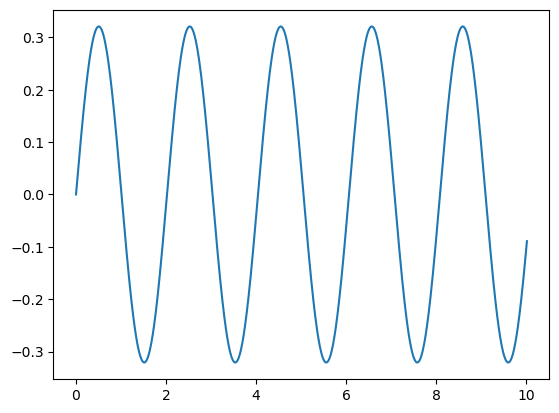

In [9]:
y, t = RK4(SimplePendulum2, [0.0, 1.0], params=(9.8,1.0))
plt.plot(t, y[0])

In [28]:
E = T + V
m1, m2, l1, l2, g, t = smp.symbols("m1 m2 l1 l2 g t")
E_lambd = smp.lambdify((t, g, m1, m2, l1, l2, theta1, theta2, omega1, omega2), E, "numpy")

g = 9.8
m1 = 1.0
m2 = 1.0
l1 = 1.0
l2 = 1.0
x0 = [0.0,2.0,0.0,4.0]
x01 = [0.0,0.0]
v01=[2.0, 4.0]
h=1e-4
tFin=4.0

from timeit import default_timer as timer

start = timer()
y, t = RK4(doublePendulum, x0=x0, params=(g, m1, m2, l1, l2), h=h, tFin=tFin)
stop = timer()
energyTime2 = E_lambd(t,g,m1,m2,l1,l2,y[0],y[2],y[1],y[3])
print(stop - start)



9.4418426000002


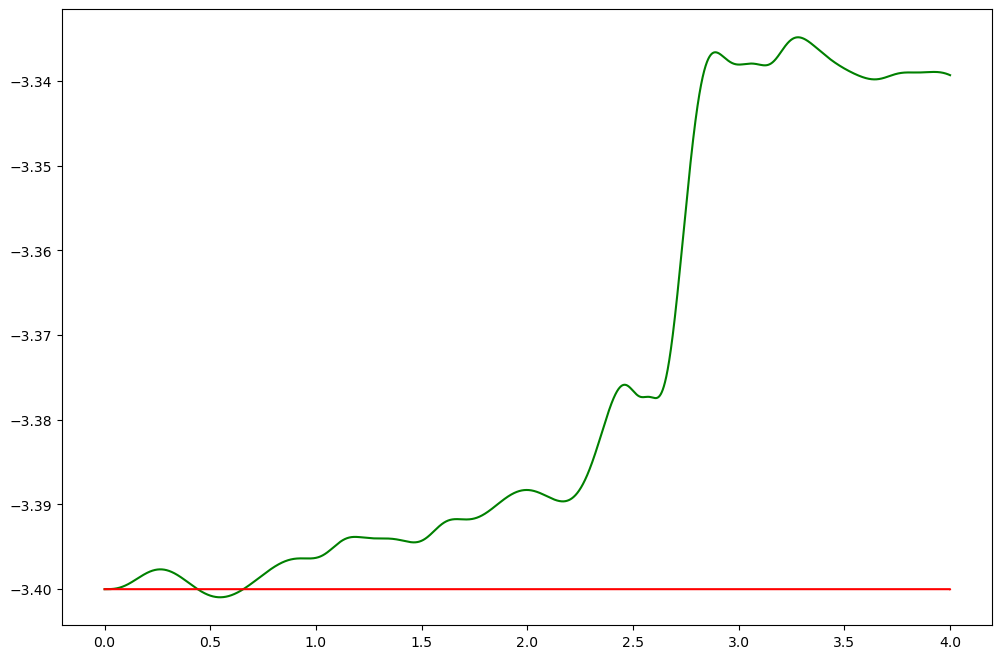

In [29]:
y,vy,t = SY4(doublePendulumVerlet, x01, v01, params=(g, m1, m2, l1, l2), h=h, tFin=tFin)
energyTime1 = E_lambd(t,g,m1,m2,l1,l2,y[0], y[1], vy[0], vy[1])

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(t, energyTime1, color="green")
ax.plot(t, energyTime2, color="red")

In [27]:
start = timer()
y, t = RK4(SimplePendulum2, x0=[0.0, 1.0], params=(g,l1), h=1e-4, tFin=10.0)
stop = timer()
print(f"Time taken = {stop - start} seconds")


Time taken = 18.553885400000127 seconds
